In [6]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import sklearn
from tqdm import tqdm
import random
import matplotlib.pyplot as plt

import data_interface
import mnar_blackout_lds

random.seed(42)
np.random.seed(42)

# Load the data
x_t, m_t, meta = data_interface.load_panel()

# Load evaluation windows
# Prefer dataframe form if your helper supports it
try:
    eval_df = data_interface.get_eval_windows("data", as_dataframe=True)
except TypeError:
    # fallback if your function returns list-of-dicts
    evaluation_windows = data_interface.get_eval_windows("data")
    eval_df = pd.DataFrame(evaluation_windows)

print(eval_df.shape)
eval_df.head()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(1764, 7)


,window_id,detector_id,blackout_start,blackout_end,len_steps,test_type,horizon_steps
0,0,005es15036,2015-01-01 00:05:00,2015-01-01 00:30:00,6,impute,NaN
1,0,005es15036,2015-01-01 00:05:00,2015-01-01 00:30:00,6,forecast,1.0
2,0,005es15036,2015-01-01 00:05:00,2015-01-01 00:30:00,6,forecast,3.0
3,0,005es15036,2015-01-01 00:05:00,2015-01-01 00:30:00,6,forecast,6.0
4,1,005es15036,2015-01-01 00:05:00,2015-01-01 01:00:00,12,impute,NaN


In [7]:
print("Rows by test_type:")
print(eval_df["test_type"].value_counts())

print("\nRows by horizon (forecast only):")
print(eval_df.loc[eval_df["test_type"]=="forecast", "horizon_steps"].value_counts().sort_index())

# Check that each window_id has 1 impute + 3 forecast rows
per_id = eval_df.groupby("window_id")["test_type"].value_counts().unstack(fill_value=0)
print("\nPer-window_id row pattern (head):")
print(per_id.head())

assert (per_id.get("impute", 0) == 1).all(), "Some window_id missing impute row"
assert (per_id.get("forecast", 0) == 3).all(), "Some window_id missing forecast rows"
print("\nManifest structure looks consistent.")


Rows by test_type:
test_type
forecast    1323
impute       441
Name: count, dtype: int64

Rows by horizon (forecast only):
horizon_steps
1.0    441
3.0    441
6.0    441
Name: count, dtype: int64

Per-window_id row pattern (head):
test_type  forecast  impute
window_id                  
0                 3       1
1                 3       1
2                 3       1
3                 3       1
4                 3       1

Manifest structure looks consistent.


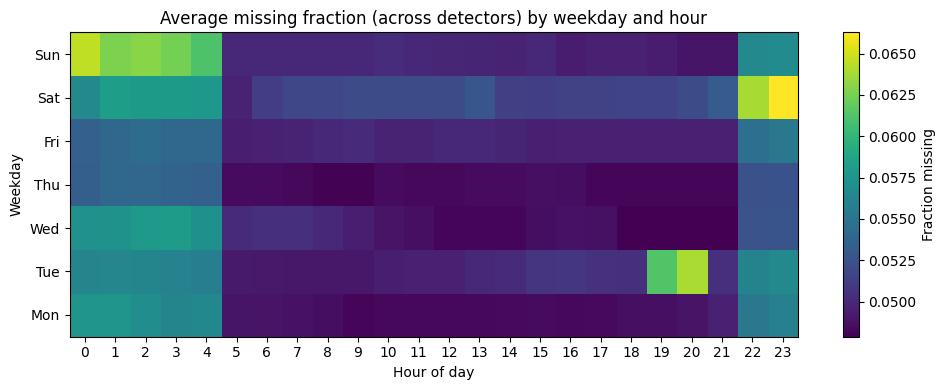

In [8]:
wide_missing = pd.DataFrame(m_t, index=meta["timestamps"], columns=meta["detectors"]).astype(bool)

missing_long = (
    wide_missing
    .stack()
    .to_frame("is_missing")
    .reset_index()
    .rename(columns={"level_0":"time", "level_1":"detector"})
)

missing_long["hour"] = missing_long["time"].dt.hour
missing_long["weekday"] = missing_long["time"].dt.dayofweek

heat = (
    missing_long
    .groupby(["weekday", "hour"])["is_missing"]
    .mean()
    .unstack("hour")
    .reindex(index=[0,1,2,3,4,5,6])
)

weekday_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

fig, ax = plt.subplots(figsize=(10, 4))
im = ax.imshow(heat.values, aspect="auto", origin="lower")
ax.set_yticks(range(7))
ax.set_yticklabels(weekday_labels)
ax.set_xticks(range(24))
ax.set_xticklabels(range(24))
ax.set_xlabel("Hour of day")
ax.set_ylabel("Weekday")
ax.set_title("Average missing fraction (across detectors) by weekday and hour")
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Fraction missing")
plt.tight_layout()
plt.show()


In [9]:
# One row per actual blackout window
windows_unique = eval_df.drop_duplicates("window_id").copy()

# Ensure datetime
windows_unique["blackout_start"] = pd.to_datetime(windows_unique["blackout_start"])
windows_unique["blackout_end"] = pd.to_datetime(windows_unique["blackout_end"])

windows_unique["hour"] = windows_unique["blackout_start"].dt.hour
windows_unique["weekday"] = windows_unique["blackout_start"].dt.dayofweek

print(windows_unique.shape)
windows_unique.head()


(441, 9)


,window_id,detector_id,blackout_start,blackout_end,len_steps,test_type,horizon_steps,hour,weekday
0,0,005es15036,2015-01-01 00:05:00,2015-01-01 00:30:00,6,impute,NaN,0,3
4,1,005es15036,2015-01-01 00:05:00,2015-01-01 01:00:00,12,impute,NaN,0,3
8,2,005es15036,2015-01-01 00:05:00,2015-01-01 02:00:00,24,impute,NaN,0,3
12,3,005es15125,2015-01-01 00:05:00,2015-01-01 00:30:00,6,impute,NaN,0,3
16,4,005es15125,2015-01-01 00:05:00,2015-01-01 01:00:00,12,impute,NaN,0,3


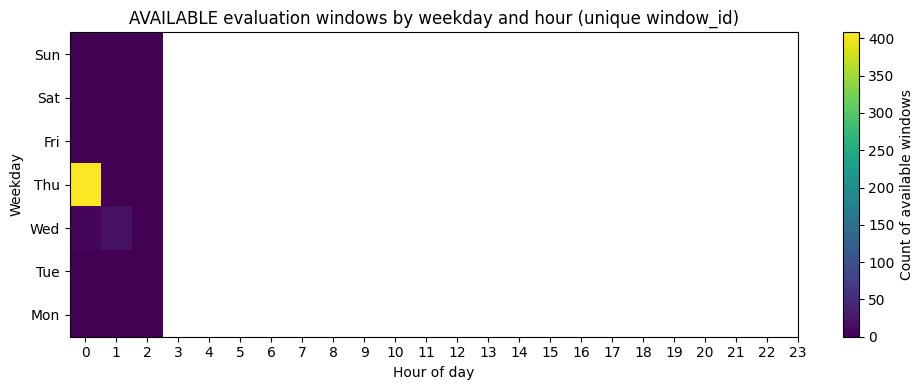

In [11]:
avail = (
    windows_unique
    .groupby(["weekday", "hour"])
    .size()
    .unstack("hour", fill_value=0)
    .reindex(index=[0,1,2,3,4,5,6], fill_value=0)
)

fig, ax = plt.subplots(figsize=(10, 4))
im = ax.imshow(avail.values, aspect="auto", origin="lower")
ax.set_yticks(range(7))
ax.set_yticklabels(weekday_labels)
ax.set_xticks(range(24))
ax.set_xticklabels(range(24))
ax.set_xlabel("Hour of day")
ax.set_ylabel("Weekday")
ax.set_title("AVAILABLE evaluation windows by weekday and hour (unique window_id)")
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Count of available windows")
plt.tight_layout()
plt.show()


In [7]:
evaluation_windows = data_interface.get_eval_windows("data")

In [8]:
from collections import defaultdict

def stratified_month_sampling(data, n_per_month, ts_key="blackout_start"):
    buckets = defaultdict(list)

    for item in data:
        ts = item[ts_key]
        month_key = (ts.year, ts.month)
        buckets[month_key].append(item)

    result = []
    for month_key, items in buckets.items():
        if len(items) < n_per_month:
            picks = random.choices(items, k=n_per_month)
        else:
            picks = random.sample(items, n_per_month)
        result.extend(picks)

    return result


In [9]:
impute_evaluation_windows = [window for window in evaluation_windows if window["test_type"] == "impute"]
forecast_1_evaluation_windows = [window for window in evaluation_windows if window["test_type"] == "forecast" and window["horizon_steps"] == 1]
forecast_3_evaluation_windows = [window for window in evaluation_windows if window["test_type"] == "forecast" and window["horizon_steps"] == 3]
forecast_6_evaluation_windows = [window for window in evaluation_windows if window["test_type"] == "forecast" and window["horizon_steps"] == 6]

In [10]:
impute_evaluation_windows_val = stratified_month_sampling(impute_evaluation_windows, n_per_month=25, ts_key="blackout_start")
forecast_1_evaluation_windows_val = stratified_month_sampling(forecast_1_evaluation_windows, n_per_month=12, ts_key="blackout_start")
forecast_3_evaluation_windows_val = stratified_month_sampling(forecast_3_evaluation_windows, n_per_month=12, ts_key="blackout_start")
forecast_6_evaluation_windows_val = stratified_month_sampling(forecast_6_evaluation_windows, n_per_month=12, ts_key="blackout_start")

In [11]:
impute_times = [window["blackout_start"] for window in impute_evaluation_windows]
forecast_1_times = [window["blackout_start"] for window in forecast_1_evaluation_windows]
forecast_3_times = [window["blackout_start"] for window in forecast_3_evaluation_windows]
forecast_6_times = [window["blackout_start"] for window in forecast_6_evaluation_windows]

In [12]:
evaluation_windows_val = (forecast_1_evaluation_windows_val +
                              forecast_3_evaluation_windows_val +
                              forecast_6_evaluation_windows_val + impute_evaluation_windows_val)

In [13]:
np.testing.assert_array_equal(np.array(impute_times), np.array(forecast_1_times))
np.testing.assert_array_equal(np.array(impute_times), np.array(forecast_3_times))
np.testing.assert_array_equal(np.array(impute_times), np.array(forecast_6_times))

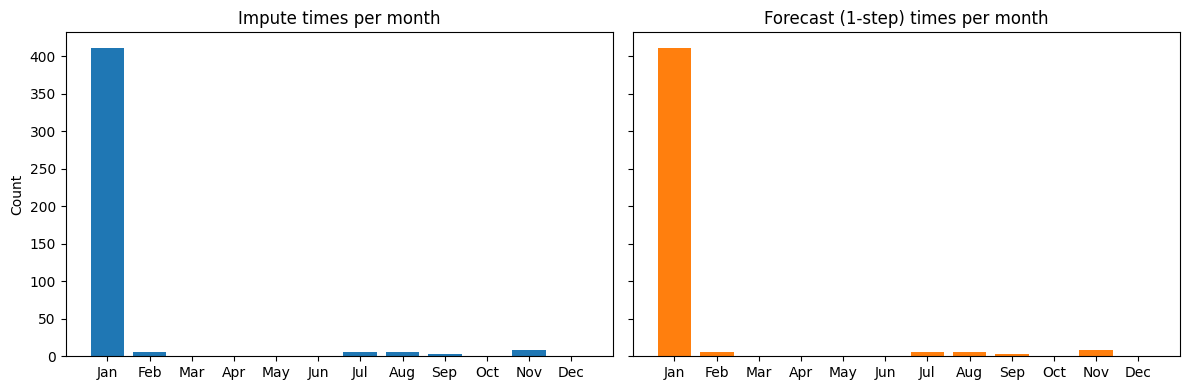

In [14]:
import pandas as pd
import numpy as np
import calendar

import matplotlib.pyplot as plt

def month_counts(times):
    # convert to datetime and extract month numbers 1-12
    months = pd.to_datetime(times).month
    counts = np.bincount(months, minlength=13)[1:]  # drop index 0
    return counts

impute_counts = month_counts(impute_times)
forecast1_counts = month_counts(forecast_1_times)

month_labels = [calendar.month_abbr[m] for m in range(1, 13)]

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
axes[0].bar(month_labels, impute_counts, color='C0')
axes[0].set_title('Impute times per month')
axes[0].set_ylabel('Count')

axes[1].bar(month_labels, forecast1_counts, color='C1')
axes[1].set_title('Forecast (1-step) times per month')

plt.tight_layout()
plt.show()

In [15]:
evaluation_windows_val[0]

{'window_id': 64,
 'detector_id': '005es16396',
 'blackout_start': Timestamp('2015-01-01 00:05:00'),
 'blackout_end': Timestamp('2015-01-01 01:00:00'),
 'len_steps': 12,
 'test_type': 'forecast',
 'horizon_steps': 1.0}

In [16]:
def mask_evaluation_windows(x_t, m_t, evaluation_windows_val, meta):
    x_t_masked = x_t.copy()
    m_t_masked = m_t.copy()

    for window in evaluation_windows_val:
        start_idx = np.where(meta["timestamps"]==window["blackout_start"])[0][0]
        end_idx = np.where(meta["timestamps"]==window["blackout_end"])[0][0]
        detector_idx = np.where(meta["detectors"]==window["detector_id"])[0][0]
        
        x_t_masked[start_idx:end_idx+1, detector_idx] = np.nan
        m_t_masked[start_idx:end_idx+1, detector_idx] = 1
    
    return x_t_masked, m_t_masked

In [17]:
# Prepare training data by masking evaluation windows
x_t_train, m_t_train = mask_evaluation_windows(x_t, m_t, evaluation_windows_val, meta)

In [18]:
model_params = mnar_blackout_lds.MNARParams.init_random(K=9, D=147, seed=42)
model = mnar_blackout_lds.MNARBlackoutLDS(model_params)

In [19]:
em_train_history = model.em_train(x_t_train, m_t_train, num_iters=10)


=== EM iteration 1/10 ===
  A norm: 2.963
  Q trace: 4.939
  mean diag(R): 58.323

=== EM iteration 2/10 ===
  A norm: 2.843
  Q trace: 20.084
  mean diag(R): 30.778

=== EM iteration 3/10 ===
  A norm: 2.854
  Q trace: 28.323
  mean diag(R): 28.081

=== EM iteration 4/10 ===
  A norm: 2.860
  Q trace: 33.417
  mean diag(R): 27.769

=== EM iteration 5/10 ===
  A norm: 2.866
  Q trace: 37.173
  mean diag(R): 27.755

=== EM iteration 6/10 ===
  A norm: 2.870
  Q trace: 40.329
  mean diag(R): 27.801

=== EM iteration 7/10 ===
  A norm: 2.872
  Q trace: 43.035
  mean diag(R): 27.836

=== EM iteration 8/10 ===
  A norm: 2.874
  Q trace: 45.030
  mean diag(R): 27.845

=== EM iteration 9/10 ===
  A norm: 2.875
  Q trace: 46.315
  mean diag(R): 27.842

=== EM iteration 10/10 ===
  A norm: 2.877
  Q trace: 47.110
  mean diag(R): 27.832


### Reconstruction and Prediction

In [20]:
ekf_out = model.ekf_forward(x_t_train, m_t_train)
smoother_out = model.rts_smoother(ekf_out)

mu_filt = ekf_out["mu_filt"]
Sigma_filt = ekf_out["Sigma_filt"]
mu_smooth = smoother_out["mu_smooth"]
Sigma_smooth = smoother_out["Sigma_smooth"]

In [21]:
# Evaluate imputation performance

impute_mae_list = []
impute_mse_list = []

for window in tqdm(impute_evaluation_windows_val):
    if window["test_type"] == "impute":
        start_idx = np.where(meta["timestamps"]==window["blackout_start"])[0][0]
        end_idx = np.where(meta["timestamps"]==window["blackout_end"])[0][0]

        detector_idx = np.where(meta["detectors"]==window["detector_id"])[0][0]

        eval_x_t = x_t[start_idx:end_idx+1].copy()
        eval_mu_smooth = mu_smooth[start_idx:end_idx+1]
        eval_Sigma_smooth = Sigma_smooth[start_idx:end_idx+1]

        reconstruct_x_t, _ = model.reconstruct_from_smoother(eval_mu_smooth, eval_Sigma_smooth)

        mae = sklearn.metrics.mean_absolute_error(reconstruct_x_t[:, detector_idx], eval_x_t[:, detector_idx])
        mse = sklearn.metrics.mean_squared_error(reconstruct_x_t[:, detector_idx], eval_x_t[:, detector_idx])
        rmse = np.sqrt(mse)
        
        impute_mae_list.append([mae, window["len_steps"]])
        impute_mse_list.append([mse, window["len_steps"]])

final_mae = np.average([item[0] for item in impute_mae_list], weights=[item[1] for item in impute_mae_list])
final_mse = np.average([item[0] for item in impute_mse_list], weights=[item[1] for item in impute_mse_list])
final_rmse = np.sqrt(final_mse)

print("Final MAE (impute):", final_mae)
print("Final MSE (impute):", final_mse)
print("Final RMSE (impute):", final_rmse)

100%|██████████| 150/150 [00:02<00:00, 66.98it/s]

Final MAE (impute): 3.4530425620361296
Final MSE (impute): 18.945693974046637
Final RMSE (impute): 4.352665157584102


In [24]:
# Evaluate forecasting performance

y_actual_1_step, y_forecast_1_step = [], []
y_actual_3_step, y_forecast_3_step = [], []
y_actual_6_step, y_forecast_6_step = [], []

forecast_evaluation_windows_val = (forecast_1_evaluation_windows_val +
                                   forecast_3_evaluation_windows_val +
                                   forecast_6_evaluation_windows_val)

for window in tqdm(forecast_evaluation_windows_val):
    if window["test_type"] == "forecast":
        start_idx = np.where(meta["timestamps"]==window["blackout_start"])[0][0]
        blackout_idx = start_idx - 1

        end_idx = np.where(meta["timestamps"]==window["blackout_end"])[0][0]

        detector_idx = np.where(meta["detectors"]==window["detector_id"])[0][0]

        eval_x_t = x_t[start_idx:end_idx+1].copy()

        forecast_x_t, _ = model.k_step_forecast(mu_filt, Sigma_filt, blackout_idx, k=int(window["horizon_steps"]))
        
        if int(window["horizon_steps"]) == 1:
            y_forecast_1_step.append(forecast_x_t[detector_idx])
            y_actual_1_step.append(eval_x_t[int(window["horizon_steps"])-1, detector_idx])
        elif int(window["horizon_steps"]) == 3:
            y_forecast_3_step.append(forecast_x_t[detector_idx])
            y_actual_3_step.append(eval_x_t[int(window["horizon_steps"])-1, detector_idx])
        elif int(window["horizon_steps"]) == 6:
            y_forecast_6_step.append(forecast_x_t[detector_idx])
            y_actual_6_step.append(eval_x_t[int(window["horizon_steps"])-1, detector_idx])

mae_1_step = sklearn.metrics.mean_absolute_error(y_forecast_1_step, y_actual_1_step)
mse_1_step = sklearn.metrics.mean_squared_error(y_forecast_1_step, y_actual_1_step)
rmse_1_step = np.sqrt(mse_1_step)

print("Evaluation results for forecasting:")
print("\n-----------------------------------")
print("1-step MAE (forecast):", mae_1_step)
print("1-step MSE (forecast):", mse_1_step)
print("1-step RMSE (forecast):", rmse_1_step)


mae_3_step = sklearn.metrics.mean_absolute_error(y_forecast_3_step, y_actual_3_step)
mse_3_step = sklearn.metrics.mean_squared_error(y_forecast_3_step, y_actual_3_step)
rmse_3_step = np.sqrt(mse_3_step)
print("\n-----------------------------------")
print("3-step MAE (forecast):", mae_3_step)
print("3-step MSE (forecast):", mse_3_step)
print("3-step RMSE (forecast):", rmse_3_step)

mae_6_step = sklearn.metrics.mean_absolute_error(y_forecast_6_step, y_actual_6_step)
mse_6_step = sklearn.metrics.mean_squared_error(y_forecast_6_step, y_actual_6_step)
rmse_6_step = np.sqrt(mse_6_step)
print("\n-----------------------------------")
print("6-step MAE (forecast):", mae_6_step)
print("6-step MSE (forecast):", mse_6_step)
print("6-step RMSE (forecast):", rmse_6_step)

100%|██████████| 216/216 [00:00<00:00, 4544.05it/s]

Evaluation results for forecasting:

-----------------------------------
1-step MAE (forecast): 3.4776296847612804
1-step MSE (forecast): 15.018761781728118
1-step RMSE (forecast): 3.8754047248936616

-----------------------------------
3-step MAE (forecast): 2.560561871892168
3-step MSE (forecast): 10.082477986606477
3-step RMSE (forecast): 3.175291795505805

-----------------------------------
6-step MAE (forecast): 2.2728913685590864
6-step MSE (forecast): 8.422475599480508
6-step RMSE (forecast): 2.902150168320121


In [23]:
len(impute_mae_list), len(y_actual_1_step), len(y_actual_3_step), len(y_actual_6_step)

(150, 72, 72, 72)